In [1]:
import torch    
torch.manual_seed(123)
import random
random.seed(123)

import torch.nn as nn
import os
import shutil
import itertools

from chofer_torchex.utils.data.collate import dict_sample_target_iter_concat
from chofer_torchex.utils.functional import collection_cascade, cuda_cascade
from chofer_tda_datasets import Anon10kEigenvaluePredict, Anon1kEigenvaluePredict, Anon50kEigenvaluePredict
from chofer_tda_datasets.transforms import Hdf5GroupToDict
from jmlr_2018_code.utils import *
from chofer_torchex.nn.slayer import SLayerRationalHat, LinearRationalStretchedBirthLifeTimeCoordinateTransform, prepare_batch
from sklearn.model_selection import ShuffleSplit
from collections import Counter, defaultdict
from chofer_torchex.nn.fuctional import histogram_intersection_loss

%matplotlib notebook

from torch.utils.data import DataLoader

os.environ['CUDA_VISIBLE_DEVICES'] = str(0)


class train_env:
        n_epochs = 100
        lr_initial = 0.01
        lr_epoch_step = 20
        batch_size = 100
        train_size = 0.9
        nu = 0.01
        n_target_bins = 100 


class AnonCollate:   
    def __init__(self, cuda=True):
        self.cuda = cuda
        
    def __call__(self, sample_target_iter):
        x, y = [], []
        for x_i, y_i in sample_target_iter:
            x.append(x_i)
            y.append(y_i)

        x = prepare_batch(x, 2)            
        y = torch.Tensor(y)

        if self.cuda:
            # Shifting the necessary parts of the prepared batch to the cuda
            x = (x[0].cuda(), x[1].cuda(), x[2], x[3])
            y = y.cuda()

        return x, y
    
    
coordinate_transform  = LinearRationalStretchedBirthLifeTimeCoordinateTransform(nu=train_env.nu)       
    
    
def normalize(x):
    c = x[:, 1].max()    
    return x/c


data_transforms = [
              lambda x: x['dim_0'].value,
              lambda x: torch.from_numpy(x).float(), 
              coordinate_transform,
              normalize
             ]

def histogramize(x):
    return np.histogram(x, density=True, bins=train_env.n_target_bins,range=(0,2))[0].tolist()


target_transforms = [histogramize]

collate = AnonCollate(cuda=False)   

/scratch2/chofer/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def LinearCell(n_in, n_out):
    m = nn.Sequential(nn.Linear(n_in, n_out), 
                      nn.BatchNorm1d(n_out), 
                      nn.ReLU())
    m.out_features = m[0].out_features
    return m


def Slayer(n_elements, point_dim):
    return SLayerRationalHat(n_elements, point_dimension=2, radius_init=0.5)   


class AnonCrossDatasetModel(nn.Module):    
    def __init__(self):
        super().__init__()  
        
        dim_0_n_elements = 100        
        self.dim_0 = Slayer(dim_0_n_elements, 2)          

        self.regressor = nn.Sequential(  
                                         nn.Tanh(),                                         
                                         LinearCell(dim_0_n_elements, 2*train_env.n_target_bins),
                                         LinearCell(2*train_env.n_target_bins,train_env.n_target_bins),                                     
                                         nn.Linear(train_env.n_target_bins, train_env.n_target_bins))
                         
    def forward(self, x):
        
        x = self.dim_0(x)
        x = self.regressor(x)        
        
        return x
        
    def centers_init(self, sample_target_iter):   
        x = [x for x, _ in sample_target_iter]
        dim_0 = torch.cat(x, dim=0)
        dim_0 = list({tuple(row) for row in dim_0})
        dim_0 = np.array(dim_0)
        kmeans = sklearn.cluster.KMeans(n_clusters=self.dim_0.centers.size(0), 
                                        init='k-means++', 
                                        random_state=123, 
                                        n_jobs=10, 
                                        n_init=2, )                           
        kmeans.fit(dim_0)
        centers = kmeans.cluster_centers_
        centers = torch.from_numpy(centers).float()
        self.dim_0.centers.data = centers


In [3]:
def cross_dataset_experiment(dataset_train, dataset_test):     
    dataset_train = dataset_train(data_root_folder_path='/scratch1/chofer/jmlr2018_data/')      
    dataset_train.data_transforms = data_transforms    
    dataset_train.target_transforms = target_transforms    
    
    dataset_test = dataset_test(data_root_folder_path='/scratch1/chofer/jmlr2018_data/')
    dataset_test.data_transforms = data_transforms
    dataset_test.target_transforms = target_transforms
    
    model = AnonCrossDatasetModel()
    model.centers_init(dataset_train)
    model.cuda()

    stats = defaultdict(list)

    opt=torch.optim.SGD(model.parameters(), lr=train_env.lr_initial, momentum=0.9)

    for i_epoch in range(1, train_env.n_epochs+1):      

        model.train()

        dl_train = DataLoader(dataset_train,
                          batch_size=train_env.batch_size, 
                          collate_fn=collate,
                          shuffle=True, 
                          num_workers=5)

        epoch_loss = 0

        if i_epoch % train_env.lr_epoch_step == 0:
            adapt_lr(opt, lambda lr: lr*0.5)

        for i_batch, (x, y) in enumerate(dl_train, 1):

            x = (x[0].cuda(), x[1].cuda(), x[2], x[3])
            y = y.cuda()

            y = torch.autograd.Variable(y)

            def closure():
                opt.zero_grad()
                y_hat = model(x)            
                loss = histogram_intersection_loss(y_hat, y)   
                loss.backward()
                return loss

            loss = opt.step(closure)

            epoch_loss += float(loss)
            stats['train_loss_by_batch'].append(float(loss))
            stats['centers'].append(model.dim_0.centers.data.cpu().numpy())

            print("Epoch {}/{}, Batch {}/{}".format(i_epoch, train_env.n_epochs, i_batch, len(dl_train)), end="       \r")

        stats['train_loss_by_epoch'].append(epoch_loss)
        
    dl_test = DataLoader(dataset_test,
                     batch_size=train_env.batch_size, 
                     collate_fn=collate)

    y_true = []
    y_pred = []
    
    model.eval()

    for i_batch, (x, y_true_i) in enumerate(dl_test):

        x = (x[0].cuda(), x[1].cuda(), x[2], x[3])
        y_true_i = y_true_i.cuda()
        y_pred_i = model(x)
        y_true.append(y_true_i.cpu())
        y_pred.append(y_pred_i.data.cpu())

    
#     for i, (y_true_i, y_pred_i) in enumerate(zip(y_true, y_pred)):
#         fig = plt.figure()
#         x = np.linspace(0, 2, train_env.n_target_bins)
#         plt.plot(x, y_true_i.numpy(), 'go', label='true',)
#         plt.plot(x, y_pred_i.numpy(), 'bo', label='pred')
#         plt.legend()
#         if i == 20:
#             break
#         plt.savefig('./anon_images/' + str(i) + '.png')

#     plt.show()

    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)    
    stats['y_true'] = y_true.numpy()
    stats['y_pred'] = y_pred.numpy()
    stats['test_histogram_intersection'] = -histogram_intersection_loss(y_pred, y_true, reduce=False)
    stats['model'] = model.cpu()
    
    return dict(stats)
    
    

In [4]:
result_1k_10k = cross_dataset_experiment(Anon1kEigenvaluePredict, Anon10kEigenvaluePredict)
print('')
print(result_1k_10k['test_histogram_intersection'].mean())
print(result_1k_10k['test_histogram_intersection'].std())

Epoch 100/100, Batch 50/50       
0.907078903876693
0.04511429491322123


In [5]:
with open ('/tmp/anon_1k_10k_true.np', 'w') as f:
    np.savetxt(f, result_1k_10k['y_true'])
    
with open ('/tmp/anon_1k_10k_pred.np', 'w') as f:
    np.savetxt(f, result_1k_10k['y_pred'])

In [10]:
result_10k_50k = cross_dataset_experiment(Anon10kEigenvaluePredict, Anon50kEigenvaluePredict)
print('')
print(result_10k_50k['test_histogram_intersection'].mean())
print(result_10k_50k['test_histogram_intersection'].std())

Epoch 100/100, Batch 31/31       
0.8879265189170837
nan


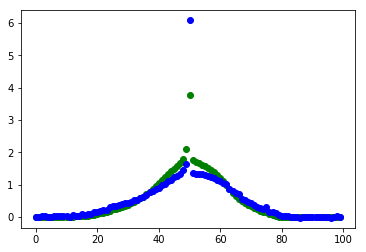

In [17]:
with open ('/tmp/anon_10k_50k_true.np', 'w') as f:
    np.savetxt(f, result_10k_50k['y_true'])
    
with open ('/tmp/anon_10k_50k_pred.np', 'w') as f:
    np.savetxt(f, result_10k_50k['y_pred'])

plt.figure()
plt.plot(result_10k_50k['y_true'][0], 'go')
plt.plot(result_10k_50k['y_pred'][0], 'bo')

In [22]:
result_1k_50k = cross_dataset_experiment(Anon1kEigenvaluePredict, Anon50kEigenvaluePredict)
print('')
print(result_1k_50k['test_histogram_intersection'].mean())
print(result_1k_50k['test_histogram_intersection'].std())

Epoch 100/100, Batch 50/50       
0.84757399559021
nan


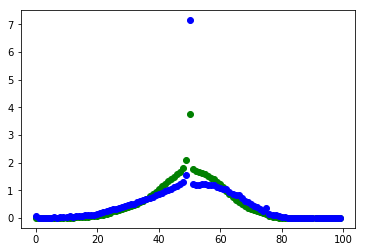

In [23]:
with open ('/tmp/anon_1k_50k_true.np', 'w') as f:
    np.savetxt(f, result_1k_50k['y_true'])
    
with open ('/tmp/anon_1k_50k_pred.np', 'w') as f:
    np.savetxt(f, result_1k_50k['y_pred'])

plt.figure()
plt.plot(result_1k_50k['y_true'][0], 'go')
plt.plot(result_1k_50k['y_pred'][0], 'bo')

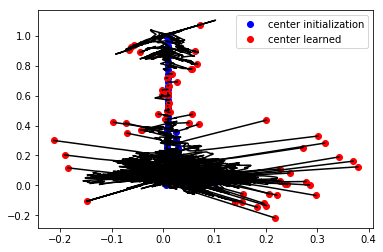

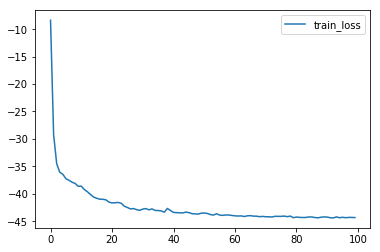

In [12]:
result = result_1k_10k
plt.figure()
c_start = result['centers'][0]
c_end = result['centers'][-1]

plt.plot(c_start[:,0], c_start[:, 1], 'bo', label='center initialization')
plt.plot(c_end[:,0], c_end[:, 1], 'ro', label='center learned')

all_centers = numpy.stack(result['centers'], axis=0)
for i in range(all_centers.shape[1]):
    points = all_centers[:,i, :]
    plt.plot(points[:, 0], points[:, 1], '-k')
    
plt.legend()

plt.figure()
plt.plot(result['train_loss_by_epoch'], label='train_loss')
# plt.plot(stats['test_loss_by_epoch'], label='test_loss')


plt.legend()
plt.show()